## Task 1: Write code to train a multi-class support vector classifier with dot-product kernel and 1- norm soft margin using the MNIST training data set. Then report the performance using MNIST test data set. There is a hyper-parameter that sets the trade-off between the margin and the training error — tune this hyper-parameter through cross-validation.

### Linear Support Vector Classifier

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# train_img_file = 'train-images.idx3-ubyte'
# train_label_file = 'train-labels.idx1-ubyte'
# test_img_file = 't10k-images.idx3-ubyte'
# test_label_file = 't10k-labels.idx1-ubyte'

In [3]:
# def convert(imgf, labelf, outf, n):
#     f = open(imgf, "rb")
#     o = open(outf, "w")
#     l = open(labelf, "rb")

#     f.read(16)
#     l.read(8)
#     images = []

#     for i in range(n):
#         image = [ord(l.read(1))]
#         for j in range(28*28):
#             image.append(ord(f.read(1)))
#         images.append(image)

#     for image in images:
#         o.write(",".join(str(pix) for pix in image)+"\n")
#     f.close()
#     o.close()
#     l.close()

# convert(train_img_file, train_label_file, "mnist_train.csv", 60000)
# convert(test_img_file, test_label_file, "mnist_test.csv", 10000)

# #Reference: https://pjreddie.com/projects/mnist-in-csv/

In [4]:
train_data = np.loadtxt("Dataset/mnist_train.csv", delimiter=",")
test_data = np.loadtxt("Dataset/mnist_test.csv", delimiter=",")

In [5]:
# Train test split

x_train = []
y_train = []
x_test = []
y_test = []
for i in range(len(train_data)):
    x_train.append(train_data[i][1:])
    y_train.append(train_data[i][:1])
for i in range(len(test_data)):
    x_test.append(test_data[i][1:])
    y_test.append(test_data[i][:1])
    
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [6]:
# Testing the sklearn results

# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# x_train = sc.fit_transform(x_train)
# x_test = sc.transform(x_test)

In [7]:
# print(x_test[0].shape)
# print(x_test[0])

In [8]:
# Implementing Standard Scaler

# Finding Mean
x_train_sum = 0
for i in x_train:
  x_train_sum += i
x_train_mean = x_train_sum/len(x_train)

# Finding Standard Deviation
x_train_sum = 0
for i in x_train:
  x_train_sum += np.power((i - x_train_mean),2)
x_train_std = np.sqrt(x_train_sum/len(x_train))

# Finding Z
for i in range(len(x_train)):
  x_train[i] = (x_train[i] - x_train_mean) / x_train_std
  x_train[i] = np.nan_to_num(x_train[i])

for i in range(len(x_test)):
  x_test[i] = (x_test[i] - x_train_mean) / x_train_std
  x_test[i] = np.nan_to_num(x_test[i])

<ipython-input-8-ebc496bfd4d6>:17: RuntimeWarning: invalid value encountered in true_divide
  x_train[i] = (x_train[i] - x_train_mean) / x_train_std
<ipython-input-8-ebc496bfd4d6>:21: RuntimeWarning: invalid value encountered in true_divide
  x_test[i] = (x_test[i] - x_train_mean) / x_train_std
<ipython-input-8-ebc496bfd4d6>:21: RuntimeWarning: divide by zero encountered in true_divide
  x_test[i] = (x_test[i] - x_train_mean) / x_train_std


In [9]:
# print(x_test[0].shape)
# print(x_test[0])

In [10]:
def projection_simplex(v , z = 1):
    n = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w

def partial_gradient(x_train, y_train, i, primal_coef):
    # Partial gradient for the ith sample.
    g = np.dot(x_train[i], primal_coef.T) + 1
    g[y_train[i]] -= 1
    return g

def violation(g, y_train, i, dual_coef):
    # Optimality violation for the ith sample.
    smallest = np.inf
    for k in range(g.shape[0]):
        if k == y[i] and dual_coef[k, i] >= C:
            continue
        elif k != y[i] and dual_coef[k, i] >= 0:
            continue

        smallest = min(smallest, g[k])

    return g.max() - smallest

def solve_subproblem(g, y_train, norms, i, dual_coef):
    # Prepare inputs to the projection.
    Ci = np.zeros(g.shape[0])
    Ci[y[i]] = C
    beta_hat = norms[i] * (Ci - dual_coef[:, i]) + g / norms[i]
    z = C * norms[i]

    # Compute projection onto the simplex.
    beta = projection_simplex(beta_hat, z)

    return Ci - dual_coef[:, i] - beta / norms[i]

def predict(x_test, primal_coef):
    decision = np.dot(x_test, primal_coef.T)
    y_pred = decision.argmax(axis=1)
    return y_pred

In [28]:
# Linear Support Vector Classifier

C_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000] # Hyperparameter Tuning via Cross Validation
y_pred_list = []

for idx in range(len(C_list)):
    C = C_list[idx]
    s, f = x_train.shape
    y = []
    for i in y_train:
        y.append(int(i))
    y = np.asarray(y)
    # Initialize primal and dual coefficients.
    c = len(np.unique(y))
    dual_coef = np.zeros((c,s), dtype = np.float64)
    primal_coef = np.zeros((c,f))
    # Pre-compute norms.
    x = np.square(x_train)
    norms = np.sqrt(np.sum(x, axis=1))

    violation_init = None
    for it in range(50):
        violation_sum = 0
        for i in range(s):
            if norms[i] == 0:
                continue

            g = partial_gradient(x_train, y, i, primal_coef)
            v = violation(g, y, i, dual_coef)
            violation_sum += v

            if v < 1e-12:
                continue

            delta = solve_subproblem(g, y, norms, i, dual_coef)
            primal_coef += (delta * x_train[i][:,np.newaxis]).T
            dual_coef[:, i] += delta

        if it == 0:
            violation_init = violation_sum

        vratio = violation_sum / violation_init
        
    y_pred = predict(x_test, primal_coef)
    y_pred_list.append(y_pred)
    

In [32]:
# Testing the sklearn results

# from sklearn.svm import SVC
# classifier = SVC(kernel = 'linear', random_state = 0)
# classifier.fit(x_train, y_train)

In [33]:
# y_pred = classifier.predict(x_test)

In [34]:
#Testing the sklearn Confusion Matrix

# from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(y_test, y_pred)
# print(cm)

In [35]:
# Confusion Matrix

confusion_matrix = np.zeros([c, c])
count = 0
for i in range(len(y_test)):
    if y_pred[i] == y_test[i]:
        count += 1
        confusion_matrix[int(y_test[i])][int(y_test[i])] = confusion_matrix[int(y_test[i])][int(y_test[i])]+1 #True Positives
    else:
        for k in range(c):
            if y_pred[i] == k:
                confusion_matrix[int(y_test[k])][int(y_test[i])] = confusion_matrix[int(y_test[k])][int(y_test[i])]+1 #False Positives

[Text(0.5, 69.0, 'Predictions'), Text(159.0, 0.5, 'Actual Values')]

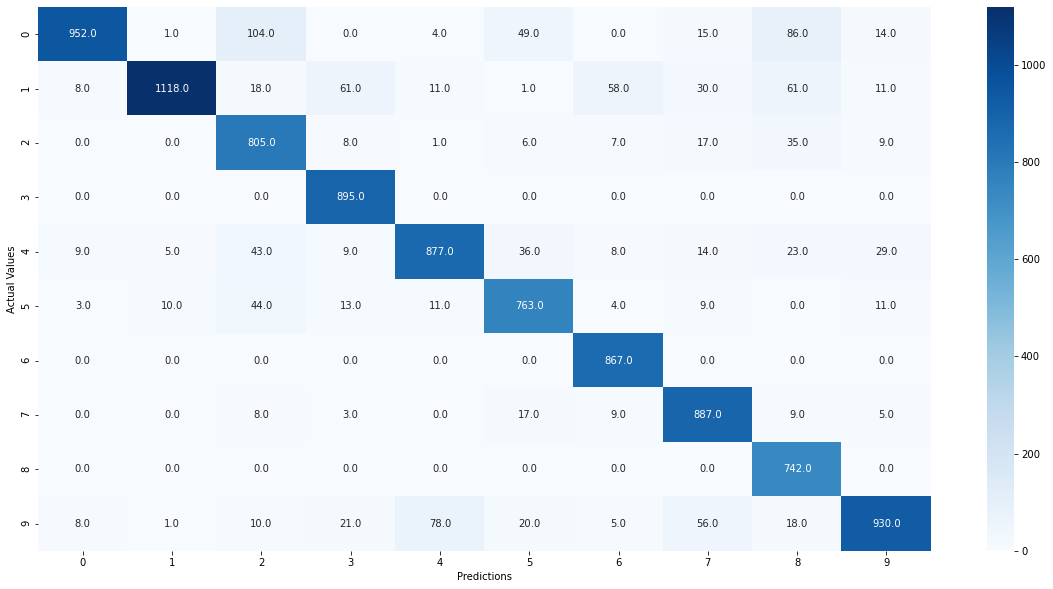

In [36]:
import seaborn as sns

# print(confusion_matrix)
plt.figure(figsize = (20,10))

sns.heatmap(confusion_matrix, annot=True, fmt='.1f', cmap='Blues').set(xlabel="Predictions", ylabel="Actual Values")

In [37]:
# Getting the TP,TN,FP,FN of each digit

true_positives = []
false_positives = []
false_negatives = []
true_negatives = []
tn_sum = 0
for i in range(c):
    fp_sum = 0
    fn_sum = 0
    true_positives.append(confusion_matrix[int(i)][int(i)]) #Append individual true positives
    tn_sum += confusion_matrix[int(i)][int(i)]
    for j in range(c):
        if i == j:
            continue
        fp_sum += confusion_matrix[int(j)][int(i)]
        fn_sum += confusion_matrix[int(i)][int(j)]
    false_positives.append(fp_sum) #Append individual false positives
    false_negatives.append(fn_sum) #Append individual false negatives
    
for i in range(c):
    true_negatives.append(tn_sum - true_positives[i])

In [38]:
# Classification Accuracy = Correct Predictions/All existing images
overall_accuracy = count/len(x_test) * 100

In [39]:
# Getting the Precision, Recall and F1 score for each digit.
digit_accuracy = [0 for i in range(c)]
digit_precision = [0 for i in range(c)]
digit_recall = [0 for i in range(c)]
digit_f1score = [0 for i in range(c)]

for i in range(c):
    digit_accuracy[i] = (true_positives[i]+true_negatives[i])/(true_positives[i]+false_positives[i]+true_negatives[i]+false_negatives[i])
    digit_precision[i] = true_positives[i]/(true_positives[i]+false_positives[i])
    digit_recall[i] = true_positives[i]/(true_positives[i]+false_negatives[i])
    digit_f1score[i] = 2 * ((digit_precision[i] * digit_recall[i])/(digit_precision[i] + digit_recall[i]))

In [40]:
print("Accuracy of the Linear Support Vector Classifier: ",round(overall_accuracy,2),"%")

Accuracy of the Linear Support Vector Classifier:  87.03 %


In [41]:
for i in range(c):
    print("Digit:",i,", Accuracy:",round(digit_accuracy[i]*100,2),"%",", Precision:",round(digit_precision[i]*100,2),"%",", Recall:",round(digit_recall[i]*100,2),"%",", F1 Score:",round(digit_f1score[i]*100,2),"%")

Digit: 0 , Accuracy: 96.71 % , Precision: 97.14 % , Recall: 77.71 % , F1 Score: 86.35 %
Digit: 1 , Accuracy: 96.97 % , Precision: 98.5 % , Recall: 81.19 % , F1 Score: 89.01 %
Digit: 2 , Accuracy: 96.61 % , Precision: 78.0 % , Recall: 90.65 % , F1 Score: 83.85 %
Digit: 3 , Accuracy: 98.72 % , Precision: 88.61 % , Recall: 100.0 % , F1 Score: 93.96 %
Digit: 4 , Accuracy: 96.92 % , Precision: 89.31 % , Recall: 83.29 % , F1 Score: 86.19 %
Digit: 5 , Accuracy: 97.42 % , Precision: 85.54 % , Recall: 87.9 % , F1 Score: 86.7 %
Digit: 6 , Accuracy: 98.98 % , Precision: 90.5 % , Recall: 100.0 % , F1 Score: 95.01 %
Digit: 7 , Accuracy: 97.87 % , Precision: 86.28 % , Recall: 94.56 % , F1 Score: 90.23 %
Digit: 8 , Accuracy: 97.44 % , Precision: 76.18 % , Recall: 100.0 % , F1 Score: 86.48 %
Digit: 9 , Accuracy: 96.76 % , Precision: 92.17 % , Recall: 81.08 % , F1 Score: 86.27 %


### Hyperparameter Tuning via Cross Validation

In [30]:
# Since C hyperparameter ets the trade-off between the margin and the training error, we tune this hyper-parameter through cross-validation.

count_list = []
for j in range(len(y_pred_list)):
    count = 0
    for i in range(len(y_test)):
        if y_pred_list[j][i] == y_test[i]:
            count += 1
    count_list.append(count)

In [31]:
# Displaying the performance of the SVM Classifier over multiple C values:

for i in range(len(count_list)):
    print("Accuracy of the Linear Support Vector Classifier for C = ",C_list[i]," : ",round((count_list[i]/len(x_test) * 100),2),"%")

Accuracy of the Linear Support Vector Classifier for C =  0.001  :  92.38 %
Accuracy of the Linear Support Vector Classifier for C =  0.01  :  92.35 %
Accuracy of the Linear Support Vector Classifier for C =  0.1  :  90.19 %
Accuracy of the Linear Support Vector Classifier for C =  1  :  87.03 %
Accuracy of the Linear Support Vector Classifier for C =  10  :  87.03 %
Accuracy of the Linear Support Vector Classifier for C =  100  :  87.03 %
Accuracy of the Linear Support Vector Classifier for C =  1000  :  87.03 %


## Task 2: Identify the Lagrange dual problem of the following primal problem:
## Given features (x1,y1),...,(xN,yN), where y1,...,yN ∈ {−1,1}. Minimize   , the weighted sum between the squared length of the separating vector and the errors, where w is the separating vector, wT ·w is the dot product, and ξi is the error made by separating vector w on feature (xi,yi), subject to yi · (wT · xi) ≥ 1 − ξi and ξi ≥ 0 for i = 1,...,N. In other words, if the “normalized feature” yixi has a margin less than 1, wT · (yixi) ≤ 1, we add a slackness term to make it 1.
## Point out what is the ”margin” in both the primal formulation and the dual formulation, what are the benefits of maximizing the margin. Characterize the support vectors. Point out the benefit of solving the dual problem instead of the primal problem.





### The objective of this task is to convert the primal problem to the dual problem, hence we first list the Karush–Kuhn–Tucker conditions to solve this problem. 
Allowing inequality constraints, the KKT approach to nonlinear programming generalizes the method of Lagrange multipliers, which allows only equality constraints. Similar to the Lagrange approach, the constrained maximization (minimization) problem is rewritten as a Lagrange function whose optimal point is a saddle point, i.e. a global maximum (minimum) over the domain of the choice variables and a global minimum (maximum) over the multipliers, which is why the Karush–Kuhn–Tucker theorem is sometimes referred to as the saddle-point theorem.

We first declare the primal variables which are: $${w -> vector}, {b-> bias}, and, {\epsilon-> slack}$$
We also declare the dual variables: $${\alpha}, and, {\mu}$$

The primal problem is written as:
$$L = {\dfrac{1}{2}}{w^T} . {w} + {C}{\sum_{i=1}^{N} \epsilon_{i}} - {\alpha_{i}}{\sum_{i=1}^{N} \epsilon_{i}} [y_{i}({w^T}{x_{i}}+b)-1+\epsilon_{i}] - {\sum_{i=1}^{N} \mu_{i}\epsilon_{i}}$$

The terms here are:
$$ Regularization -> {\dfrac{1}{2}}{w^T} . {w}, and, Penalty -> C$$

We now partially differentiate this equation with respect to primal variables such as vector, bias and slack:
$${\dfrac{\partial L}{\partial w}} -> w = {\sum_{i=1}^{N} \alpha_{i}y_{i}x_{i}}$$
$${\dfrac{\partial L}{\partial b}} -> {\sum_{i=1}^{N} \alpha_{i}y_{i}} = 0$$
$${\dfrac{\partial L}{\partial \epsilon}} -> \alpha_{i} - \mu_{i} = C$$

Revising the primal equation to dual equation:
$$L = {\sum_{i=1}^{N} \alpha_{i}} + {\dfrac{1}{2}}{\sum_{i=1,j=1}^{N} y_{i}y_{j}\alpha_{i}\alpha_{j}}{<x_{i}.x_{j}>}$$

Where $${\sum_{i=1}^{N} \alpha_{i}y_{i}} = 0, and, \alpha_{i} >= 0, and, \mu_{i} >= 0$$

### We now calculate the margins for Primal and Dual Problem:
We have two different features for two different classes in a binary classifier:
$$ (x_{1},y_{1}) -> Class +1, and, (x_{2},y_{2}) -> Class -1$$
We now have two equations:
$$ wx_{1}+b = +1$$
$$ wx_{2}+b = -1$$
Hence: $$ w(x_{1} - x_{2})+b = 0$$
Since vector w is perpendicular: $$ ||x_{1} - x_{2}|| = M$$

Let x1 and x2 be two close points in their respective regions +1 and -1: $$ x_{2}+kw = x_{1}$$ where k is a constant
We then substitute x1 in $$ wx_{1}+b = +1$$ resulting in $$ w(x_{2}+kw)+b = +1$$
Then $$ wx_{2}+b + k||w||^2 = +1 $$ where $$ wx_{2}+b = -1$$
Then $$ -1 + k||w||^2 = +1 $$
$$ k||w||^2 = 2 $$
Hence finally: $$ k = {\dfrac{2}{||w||^2}} $$
Since $$ ||x_{1} - x_{2}|| = M$$
$$M = ||kw||$$
$$M = {\dfrac{2}{||w||^2}}.||w||$$

We conclude Primal Margin $$M = {\dfrac{2}{||w||}}$$

Given the dual problem equation is to maximize L:
$$max L = {\sum_{i=1}^{N} \alpha_{i}} + {\dfrac{1}{2}}{\sum_{i=1,j=1}^{N} y_{i}y_{j}\alpha_{i}\alpha_{j}}{<x_{i}.x_{j}>}$$
We take derivative wrt alpha: $${\sum_{i=1}^{N} \alpha_{i}y_{i}} = 0$$ where $$0<=\alpha_{i}<=C$$
After finding alpha, we must now find the vector w for the highest margin of seperation: $${\sum_{i=1}^{N} \alpha_{i}y_{i}x_{i}} = w$$
We further train to find the optimal vector w and test a new datapoint: $$(x_{i}.y_{i})$$ in equation: $$({\sum_{i=1}^{N} \alpha_{i}y_{i}x_{i}}) + b = f(x)$$
To check if the new datapoint lies on the +1 region or -1 region. Hence we determined the margin for dual problem.

### Characterizing the Support Vectors:
As we know, w vector is a linear combination of x,y, alpha parameters. For every data point x, we assign an alpha value depending on the closeness to the hyperplane. the ones with the closest distance to the hyperplane is assigned a an alpha > 0 while the ones away from the hyperplane are given alpha = 0. The non zero alpha points are known as Support Vectors of an SVM.

### From the above equations, we look to maximise the margins for a couple of reasons
-> Maximising the margin M of a Support Vector Machine makes the model averse to overfitting and helps us to classify test examples better. A large margin gives more rom for new datapoints to differentiate between classes and this is better done when there is less overfitting.

-> Maximum margin is also less error prone as classifications are done at the highest certainty compared to regression models. In between 2 classes, there is close to 50% chance a new data point could be +1 or -1 with less violations affecting the classification rate.

-> Maximising the margin of an SVC can represent non-linear classification models.

### Benefits of solving the Dual Problem over the Primal Problem:
-> Any feasible solution to the dual problem gives a bound on the optimal objective function value in the primal problem.

-> Understanding the dual problem leads to specialized algorithms for some important classes of linear programming problems. Examples include the transportation simplex method, the Hungarian algorithm for the assignment problem, and the network simplex method.

-> The dual can be helpful for sensitivity analysis. Changing the primal’s right-hand side constraint vector or adding a new constraint to it can make the original primal optimal solution infeasible. However, this only changes the objective function or adds a new variable to the dual, respectively, so the original dual optimal solution is still feasible (and is usually not far from the new dual optimal solution).

-> The dual variables give the shadow prices for the primal constraints. Suppose you have a profit maximization problem with a resource constraint i. Then the value yi of the corresponding dual variable in the optimal solution tells you that you get an increase of yi in the maximum profit for each unit increase in the amount of resource i.

-> Sometimes the dual is easier to solve. A primal problem with many constraints and few variables can be converted into a dual problem with few constraints and many variables (the fewer the constraints, the fewer computations required in each iteration of the simplex method).

### References:
-> http://www.cs.utsa.edu/~bylander/cs6243/svm.pdf (Maximising Margins, Coding)

-> https://www.reisanar.com/files/Primal_Dual.pdf (Benefits of Solving Dual over Primal)

-> https://www.cs.cmu.edu/~tom/10701_sp11/slides/Kernels_SVM2_04_12_2011-ann.pdf (Solving Dual Problem from Primal Problem)

-> https://machinelearningmastery.com/support-vector-machines-for-machine-learning/ (Coding)

-> https://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf (Solving Dual Problem from Primal Problem)

## Task 3: Formulate the primal problem and derive the dual problem if there are multiple classes.